# Probing Many-Body Dynamics on Pulser

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

from pulser import Pulse, Sequence, Register
from pulser.waveforms import CompositeWaveform, RampWaveform, ConstantWaveform
from pulser.devices import Chadoq2, Mock
from pulser.simulation import Simulation

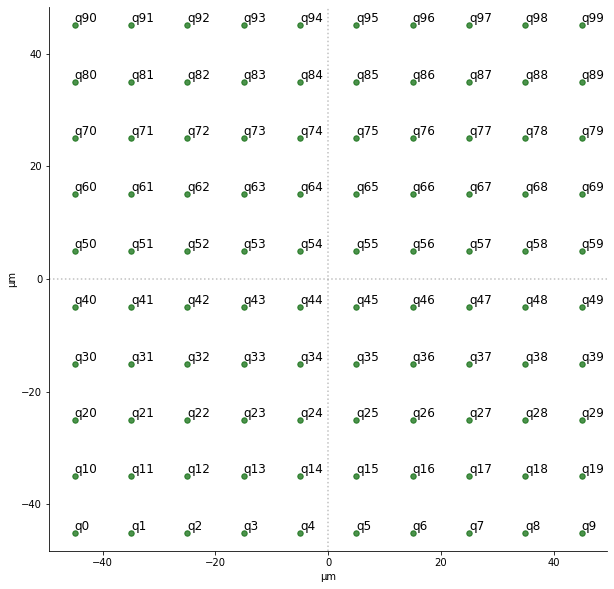

In [28]:
reg = Register.rectangle(10,10, spacing=10, prefix='q')
reg.draw()

In [21]:
# Parameters in MHz and ns
#U = 1 * 2*np.pi  # btw 1-3 Mhz*2pi. Should we include this VdW magnitude in an AFM-type Simulation?

delta_0 = -20 * 2*np.pi
delta_f = 20 * 2*np.pi
Omega_max = 2.0 * 2*np.pi  # btw 1.8-2 Mhz*2pi
t_rise = 60.
t_stop = 220.
t_end = 300.

## Z2 order: Creating the Pulse Sequence

In [22]:
hold = ConstantWaveform(t_rise, delta_0)
excite = RampWaveform(t_stop - t_rise, delta_0, delta_f)
sweep = Pulse.ConstantAmplitude(Omega_max, CompositeWaveform(hold, excite), 0.)
stay = Pulse.ConstantPulse(t_end - t_stop, 0., delta_f, 0.)

Channel: ising
t: 0 | Initial targets: q3, q2, q1, q7, q5, q0, q8, q6, q4 | Phase Reference: 0.0 
t: 0->220 | Pulse(Amp=12.6 MHz, Detuning=Composite(ConstantWaveform(60 ns, -126 MHz), RampWaveform(160 ns, -126->126 MHz)), Phase=0) | Targets: q3, q2, q1, q7, q5, q0, q8, q6, q4
t: 220->300 | Pulse(Amp=0 MHz, Detuning=126 MHz, Phase=0) | Targets: q3, q2, q1, q7, q5, q0, q8, q6, q4




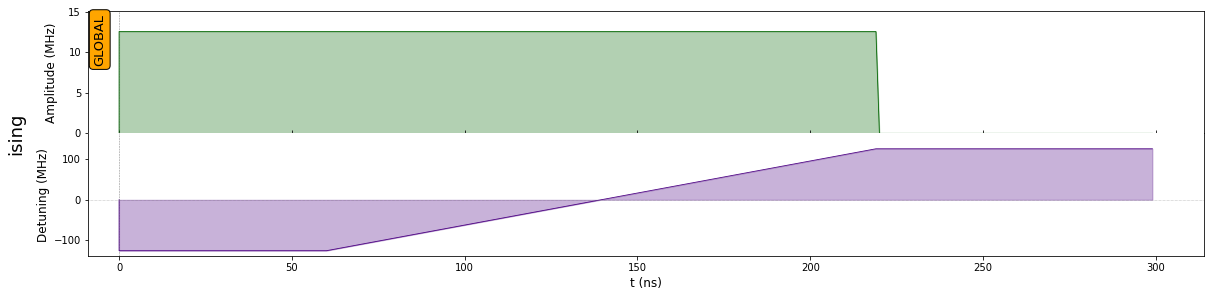

In [23]:
seq = Sequence(reg, Mock)
seq.declare_channel('ising', 'rydberg_global')

seq.add(sweep, 'ising')
seq.add(stay, 'ising')

print(seq)
seq.draw()

## Simulation

(Running with `nsteps = 10000`, `max_step=10`)

In [24]:
simul = Simulation(seq)

In [25]:
up = qutip.basis(2,0)
def occupation(j):
    prod = [qutip.qeye(2) for _ in range(simul._size)]
    prod[j] = up*up.dag()
    return qutip.tensor(prod)
    
occup_list = [occupation(j) for j in range(simul._size)]

In [26]:
simul.run(obs_list=occup_list, progress_bar=True)

Observables provided. Calculating expectation value...
10.0%. Run time:   1.74s. Est. time left: 00:00:00:15
20.0%. Run time:   3.70s. Est. time left: 00:00:00:14
30.0%. Run time:   5.40s. Est. time left: 00:00:00:12
40.0%. Run time:   6.34s. Est. time left: 00:00:00:09
50.0%. Run time:   6.93s. Est. time left: 00:00:00:06
60.0%. Run time:   8.45s. Est. time left: 00:00:00:05
70.0%. Run time:  11.71s. Est. time left: 00:00:00:05
80.0%. Run time:  17.14s. Est. time left: 00:00:00:04
90.0%. Run time:  22.00s. Est. time left: 00:00:00:02
Total run time:  26.01s


In [18]:
res = np.zeros((len(reg.qubits),int(t_end)))
for i,expv in enumerate(simul.output.expect):
    for t in range(int(t_end)):
        res[i,t] = expv[t] 

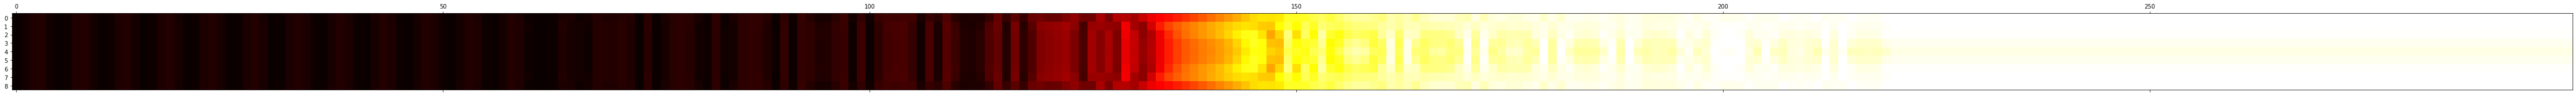

In [19]:
plt.figure(figsize=(80,50))
plt.matshow(res, cmap='hot', fignum=1)
plt.show()

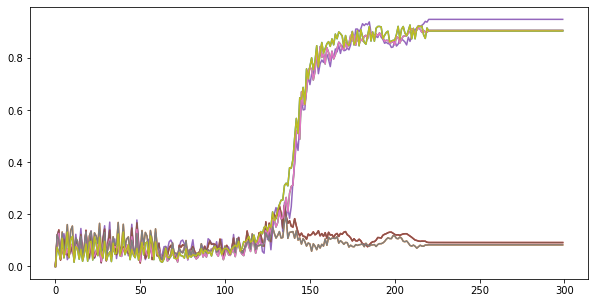

In [11]:
plt.figure(figsize=(10,5))
for expv in simul.output.expect:
    plt.plot(expv)

# Rydberg Crystals: Z3 Order

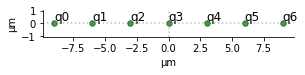

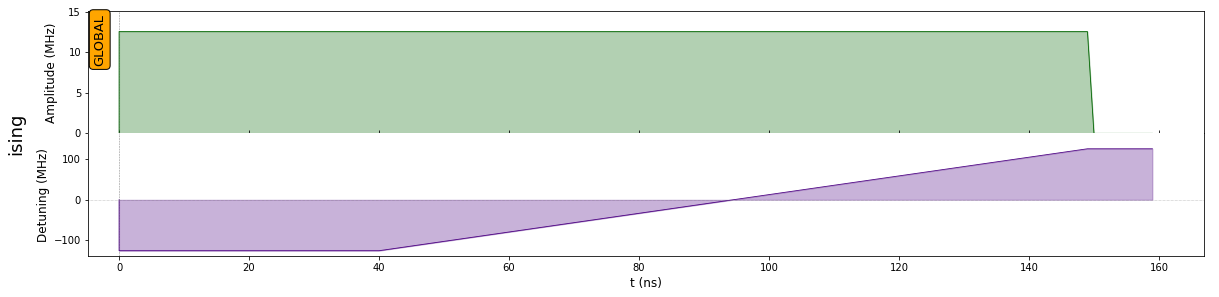

Observables provided. Calculating expectation value...
10.0%. Run time:  71.54s. Est. time left: 00:00:10:43
20.0%. Run time: 166.49s. Est. time left: 00:00:11:05
30.0%. Run time: 253.71s. Est. time left: 00:00:09:52
40.0%. Run time: 337.82s. Est. time left: 00:00:08:26
50.0%. Run time: 430.97s. Est. time left: 00:00:07:10
60.0%. Run time: 518.20s. Est. time left: 00:00:05:45
70.0%. Run time: 626.61s. Est. time left: 00:00:04:28
80.0%. Run time: 734.77s. Est. time left: 00:00:03:03
90.0%. Run time: 835.15s. Est. time left: 00:00:01:32
Total run time: 931.42s


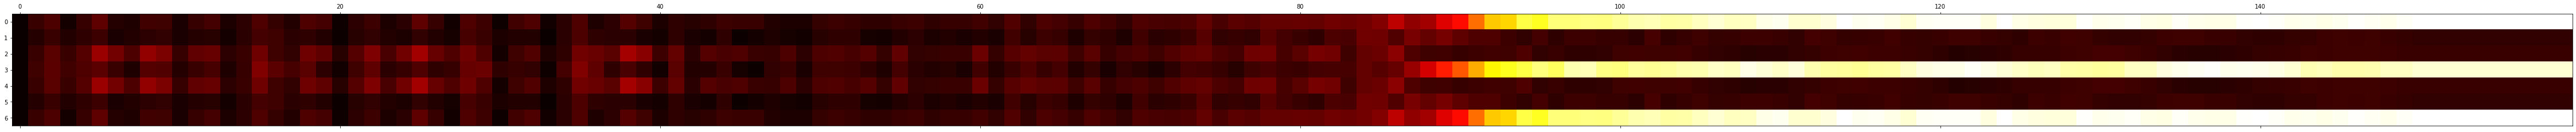

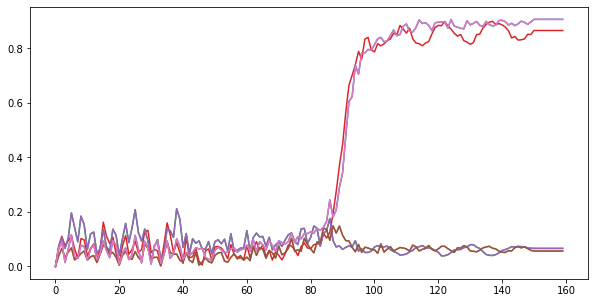

In [2]:
reg = Register.rectangle(1,7, spacing=3., prefix='q')
reg.draw()

# Parameters in MHz and ns
#U = 1 * 2*np.pi  # btw 1-3 Mhz*2pi. Should we include this VdW magnitude in an AFM-type Simulation?

delta_0 = -20 * 2*np.pi
delta_f = 20 * 2*np.pi
Omega_max = 2.0 * 2*np.pi  # btw 1.8-2 Mhz*2pi
t_rise = 40.
t_stop = 150.
t_end = 160.

#
hold = ConstantWaveform(t_rise, delta_0)
excite = RampWaveform(t_stop - t_rise, delta_0, delta_f)
sweep = Pulse.ConstantAmplitude(Omega_max, CompositeWaveform(hold, excite), 0.)
stay = Pulse.ConstantPulse(t_end - t_stop, 0., delta_f, 0.)

#
seq = Sequence(reg, Mock)
seq.declare_channel('ising', 'rydberg_global')

seq.add(sweep, 'ising')
seq.add(stay, 'ising')

#print(seq)
seq.draw()

simul = Simulation(seq)

#
up = qutip.basis(2,0)
def occupation(j):
    prod = [qutip.qeye(2) for _ in range(simul._size)]
    prod[j] = up*up.dag()
    return qutip.tensor(prod)
    
occup_list = [occupation(j) for j in range(simul._size)]

#
simul.run(obs_list=occup_list, progress_bar=True)

#
res = np.zeros((len(reg.qubits),int(t_end)))
for i,expv in enumerate(simul.output.expect):
    for t in range(int(t_end)):
        res[i,t] = expv[t] 
        
        
#
plt.figure(figsize=(80,50))
plt.matshow(res, cmap='hot', fignum=1)

#
plt.figure(figsize=(10,5))
for expv in simul.output.expect:
    plt.plot(expv)
    
plt.show()

# Rydberg Crystals: Z4 Order

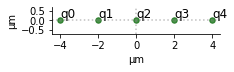

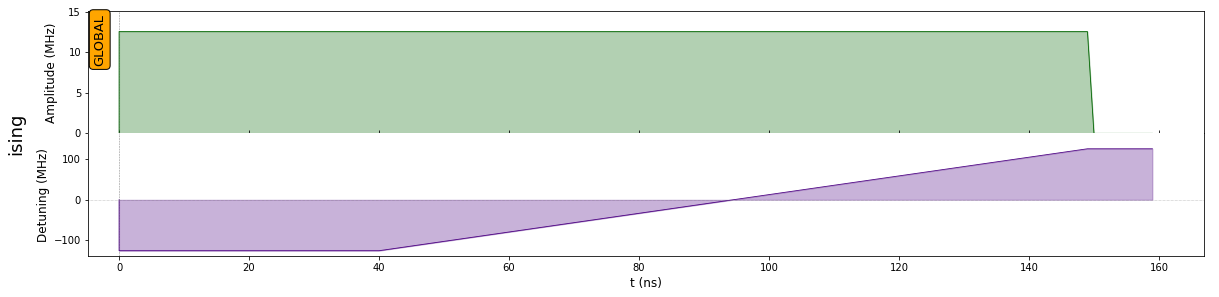

Observables provided. Calculating expectation value...
10.0%. Run time: 138.38s. Est. time left: 00:00:20:45
20.0%. Run time: 276.91s. Est. time left: 00:00:18:27
30.0%. Run time: 410.55s. Est. time left: 00:00:15:57
40.0%. Run time: 520.97s. Est. time left: 00:00:13:01


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy-1.5.4-py3.9-macosx-10.9-x86_64.egg/scipy/integrate/_ode.py:1011: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.

In [3]:
reg = Register.rectangle(1,5, spacing=2., prefix='q')
reg.draw()

# Parameters in MHz and ns
#U = 1 * 2*np.pi  # btw 1-3 Mhz*2pi. Should we include this VdW magnitude in an AFM-type Simulation?

delta_0 = -20 * 2*np.pi
delta_f = 20 * 2*np.pi
Omega_max = 2.0 * 2*np.pi  # btw 1.8-2 Mhz*2pi
t_rise = 40.
t_stop = 150.
t_end = 160.

#
hold = ConstantWaveform(t_rise, delta_0)
excite = RampWaveform(t_stop - t_rise, delta_0, delta_f)
sweep = Pulse.ConstantAmplitude(Omega_max, CompositeWaveform(hold, excite), 0.)
stay = Pulse.ConstantPulse(t_end - t_stop, 0., delta_f, 0.)

#
seq = Sequence(reg, Mock)
seq.declare_channel('ising', 'rydberg_global')

seq.add(sweep, 'ising')
seq.add(stay, 'ising')

#print(seq)
seq.draw()

simul = Simulation(seq)

#
up = qutip.basis(2,0)
def occupation(j):
    prod = [qutip.qeye(2) for _ in range(simul._size)]
    prod[j] = up*up.dag()
    return qutip.tensor(prod)
    
occup_list = [occupation(j) for j in range(simul._size)]

#
simul.run(obs_list=occup_list, progress_bar=True)

#
res = np.zeros((len(reg.qubits),int(t_end)))
for i,expv in enumerate(simul.output.expect):
    for t in range(int(t_end)):
        res[i,t] = expv[t] 
        
        
#
plt.figure(figsize=(80,50))
plt.matshow(res, cmap='hot', fignum=1)

#
plt.figure(figsize=(10,5))
for expv in simul.output.expect:
    plt.plot(expv)
    
plt.show()